## 1. The World Bank's international debt data
<p>No es que los humanos solo tengamos deudas para administrar nuestras necesidades. Un país también puede endeudarse para administrar su economía. Por ejemplo, el gasto en infraestructura es un ingrediente costoso requerido para que los ciudadanos de un país lleven una vida cómoda. El Banco Mundial es la organización que proporciona deuda a los países.</p>

<!-- <p>En este notebook, vamos a analizar los datos de la deuda internacional recopilados por el Banco Mundial. El conjunto de datos contiene información sobre el monto de la deuda (en USD) que deben los países en desarrollo en varias categorías.</p>  -->
    

"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD
"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD
"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD
"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD
"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD
"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD
"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD
"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD
"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD
"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD
"PPG, official creditors (INT, current US$)",DT.INT.OFFT.CD
"Principal repayments on external debt, long-term (AMT, current US$)",DT.AMT.DLXF.CD
"Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$)",DT.INT.DPNG.CD
"PPG, bonds (AMT, current US$)",DT.AMT.PBND.CD
"PPG, bonds (INT, current US$)",DT.INT.PBND.CD
"PPG, commercial banks (AMT, current US$)",DT.AMT.PCBK.CD
"PPG, commercial banks (DIS, current US$)",DT.DIS.PCBK.CD
"PPG, commercial banks (INT, current US$)",DT.INT.PCBK.CD
"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD
"PPG, other private creditors (DIS, current US$)",DT.DIS.PROP.CD
"PPG, other private creditors (INT, current US$)",DT.INT.PROP.CD
"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD
"PPG, private creditors (DIS, current US$)",DT.DIS.PRVT.CD
"PPG, private creditors (INT, current US$)",DT.INT.PRVT.CD
"Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$)",DT.AMT.DPNG.CD

<p>Vamos a encontrar las respuestas a preguntas como:

<p>¿Cuál es el monto total de la deuda que deben los países enumerados en el conjunto de datos?
<p>¿Qué país posee la cantidad máxima de deuda y cómo se ve esa cantidad?
<p>¿Cuál es el monto promedio de la deuda de los países a través de diferentes indicadores de deuda?
    
Además tenemos otro dataset en el que encontramos información histórica de algunos índices de desarrollo, entre los que se encuentran algunos de deuda como son:

Series Name,Series Code
"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN

"Central government debt, total (current LCU)",GC.DOD.TOTL.CN

"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS

#### 1. Inicializar y cargar el contexto spark

In [40]:
    # Importo FindSpark para encontrar Spark en el sistema
import findspark
findspark.init()
    
    # Inicio el contesto spark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
    
    # Debido aque voy a trabajar con sparkSQL introduzo el contexto sparksql
from pyspark.sql import SparkSession
    # Importamos Row para darle nombre a los RDD
from pyspark.sql import Row
    # Importamos las funciones de pysparksql
from pyspark.sql.functions import *
    # Importamos los distintos tipos que puede ser uno a uno o todos juntos con el simbolo *
from pyspark.sql.types import *
from pyspark.sql.types import StructType, IntegerType, StringType, FloatType

    #Importamos Statictics de mllib para calcular los estadisticos basicos
from pyspark.mllib.stat import Statistics  

    # Importamos Handy para hacer Scatter Plots
from handyspark import *
    # Importamos Correlation de stats para calcular correlaciones
from pyspark.ml.stat import Correlation

    # Configuracion de spark a 5 gb
from pyspark import SparkConf
conf = SparkConf()
conf.set("spark.driver.memory", "5g")

    # Creo la SparkSession
spark = SparkSession.builder \
            .config(conf=conf) \
            .master("local[*]") \
            .getOrCreate()

In [41]:
    # Creamos los objetos con los nombres de los archivos para llamarlos luego
ind_desarrollo = "indicadores_desarrollo.csv"
ind_deuda = "indicadores_deuda.csv"

### Indice de desarrollo

In [42]:
    # Cargamos el fichero con los indices de desarrollo como rdd
raw_desarrollo = sc.textFile(ind_desarrollo)
    
    # Muestrame el tipo de objeto que se acaba de crear
print(type(raw_desarrollo))

<class 'pyspark.rdd.RDD'>


In [43]:
    # Le aplico la accion de transformacion take para observar como esta 
raw_desarrollo.take(5)

['country_name,country_code,anho,GC.DOD.TOTL.CN,GC.DOD.TOTL.GD.ZS,SP.DYN.CBRT.IN',
 'Albania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259',
 'Albania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197',
 'Albania,ALB,2016 [YR2016],1188814490000,80.7355748396923,12.08',
 'Australia,AUS,2014 [YR2014],674700000,0.042207528166503,13.2']

Aqui ya nos vamos dando cuenta de que lleva cabecera y como estan estructurados los datos

In [44]:
    # otra de las acciones principales que se pueden aplicar a un rdd una vez hecha la transformacion es count
raw_desarrollo.count()

135

In [45]:
    # Seleccionamos la primera fila como la cabecera 
header = raw_desarrollo.take(1)[0]
    # Eliminamos la cabecera del rdd para poder trabajar con el
raw_desarrollo = raw_desarrollo \
    .filter(lambda line: line!=header)

In [46]:
    # Comprobamos como queda el rdd
raw_desarrollo.take(5)

['Albania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259',
 'Albania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197',
 'Albania,ALB,2016 [YR2016],1188814490000,80.7355748396923,12.08',
 'Australia,AUS,2014 [YR2014],674700000,0.042207528166503,13.2',
 'Australia,AUS,2015 [YR2015],762718000,0.0469480198522591,12.9']

In [47]:
    # Parseamos el rdd con la funcion split
raw_desarrollo_parsed = raw_desarrollo \
                        .map(lambda x: x.split(","))

    # Con la funcion de accion take le pedimos que nos muestre los resultados
raw_desarrollo_parsed.take(5)

[['Albania',
  'ALB',
  '2014 [YR2014]',
  '1023040800000',
  '73.3202469198429',
  '12.259'],
 ['Albania',
  'ALB',
  '2015 [YR2015]',
  '1145500940000',
  '79.8644448747259',
  '12.197'],
 ['Albania',
  'ALB',
  '2016 [YR2016]',
  '1188814490000',
  '80.7355748396923',
  '12.08'],
 ['Australia',
  'AUS',
  '2014 [YR2014]',
  '674700000',
  '0.042207528166503',
  '13.2'],
 ['Australia',
  'AUS',
  '2015 [YR2015]',
  '762718000',
  '0.0469480198522591',
  '12.9']]

In [48]:
    # Aplicamos un persist ya que estaremos utilizando el fichero mas adelante
raw_desarrollo_parsed.persist()

PythonRDD[7] at RDD at PythonRDD.scala:53

In [49]:
    # ejecutamos el conteo para ver los registros
raw_desarrollo_parsed.count() 

134

Ahora voy a cargar el fichero como spark Data Frame para poder trabajar con el con comando SQL

In [50]:
    # Ya que conocemos la estructura del fichero le pongo la estructura que debe llevar
schema = StructType([
    StructField("country_name", StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("year", StringType(), True),
    StructField("GC_DOD_TOTL_CN", FloatType(), True),
    StructField("GC_DOD_TOTL_GD_ZS", FloatType(), True),
    StructField("SP_DYN_CBRT_IN", FloatType(), True)
])

    # Utilizamos la estructura anterior para crear el fichero. Le pedimos que nos ponga la cabecera y lo separe por ,
raw_desarrollo_parsed_data = spark \
    .read.format("com.databricks.spark.csv") \
    .option("header", "true") \
    .schema(schema) \
    .option("mode", "PERMISSIVE") \
    .option("delimiter", ",") \
    .load(ind_desarrollo)
raw_desarrollo_parsed_data.take(2)


[Row(country_name='Albania', country_code='ALB', year='2014 [YR2014]', GC_DOD_TOTL_CN=1023040815104.0, GC_DOD_TOTL_GD_ZS=73.32024383544922, SP_DYN_CBRT_IN=12.258999824523926),
 Row(country_name='Albania', country_code='ALB', year='2015 [YR2015]', GC_DOD_TOTL_CN=1145500991488.0, GC_DOD_TOTL_GD_ZS=79.86444854736328, SP_DYN_CBRT_IN=12.196999549865723)]

In [51]:
    # Muestrame el esquema con printSchema para ver si resulto bien la carga del archivo
raw_desarrollo_parsed_data.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- year: string (nullable = true)
 |-- GC_DOD_TOTL_CN: float (nullable = true)
 |-- GC_DOD_TOTL_GD_ZS: float (nullable = true)
 |-- SP_DYN_CBRT_IN: float (nullable = true)



### Indice de deuda

In [52]:
    # Ahora hare lo mismo con el fichero de indices de deuda. Le coloco la estructura y luego la usamos
schema = StructType([
    StructField("country_name", StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("DT_AMT_BLAT_CD", FloatType(), True),
    StructField("DT_AMT_DLXF_CD", FloatType(), True),
    StructField("DT_AMT_DPNG_CD", FloatType(), True),
    StructField("DT_AMT_MLAT_CD", FloatType(), True),
    StructField("DT_AMT_OFFT_CD", FloatType(), True),
    StructField("DT_AMT_PBND_CD", FloatType(), True),
    StructField("DT_AMT_PCBK_CD", FloatType(), True),
    StructField("DT_AMT_PROP_CD", FloatType(), True),
    StructField("DT_AMT_PRVT_CD", FloatType(), True),
    StructField("DT_DIS_BLAT_CD", FloatType(), True),
    StructField("DT_DIS_DLXF_CD", FloatType(), True),
    StructField("DT_DIS_MLAT_CD", FloatType(), True),
    StructField("DT_DIS_OFFT_CD", FloatType(), True),
    StructField("DT_DIS_PCBK_CD", FloatType(), True),
    StructField("DT_DIS_PROP_CD", FloatType(), True),
    StructField("DT_DIS_PRVT_CD", FloatType(), True),
    StructField("DT_INT_BLAT_CD", FloatType(), True),
    StructField("DT_INT_DLXF_CD", FloatType(), True),
    StructField("DT_INT_DPNG_CD", FloatType(), True),
    StructField("DT_INT_MLAT_CD", FloatType(), True),
    StructField("DT_INT_OFFT_CD", FloatType(), True),
    StructField("DT_INT_PBND_CD", FloatType(), True),
    StructField("DT_INT_PCBK_CD", FloatType(), True),
    StructField("DT_INT_PROP_CD", FloatType(), True),
    StructField("DT_INT_PRVT_CD", FloatType(), True)
])

    # Cargamos el spark Data Frame del mismo modo que trabajamos el fichero de indices de desarrollo
raw_deuda_parsed = spark \
    .read.format("com.databricks.spark.csv") \
    .option("header", "true") \
    .schema(schema) \
    .option("mode", "PERMISSIVE") \
    .option("delimiter", ",") \
    .load(ind_deuda)

     # Con un take observamos los resultados
raw_deuda_parsed.take(2)

[Row(country_name='Afghanistan', country_code='AFG', DT_AMT_BLAT_CD=61739336.0, DT_AMT_DLXF_CD=100847184.0, DT_AMT_DPNG_CD=None, DT_AMT_MLAT_CD=39107844.0, DT_AMT_OFFT_CD=100847184.0, DT_AMT_PBND_CD=None, DT_AMT_PCBK_CD=None, DT_AMT_PROP_CD=None, DT_AMT_PRVT_CD=None, DT_DIS_BLAT_CD=49114728.0, DT_DIS_DLXF_CD=72894456.0, DT_DIS_MLAT_CD=23779724.0, DT_DIS_OFFT_CD=72894456.0, DT_DIS_PCBK_CD=None, DT_DIS_PROP_CD=None, DT_DIS_PRVT_CD=None, DT_INT_BLAT_CD=39903620.0, DT_INT_DLXF_CD=53239440.0, DT_INT_DPNG_CD=None, DT_INT_MLAT_CD=13335820.0, DT_INT_OFFT_CD=53239440.0, DT_INT_PBND_CD=None, DT_INT_PCBK_CD=None, DT_INT_PROP_CD=None, DT_INT_PRVT_CD=None),
 Row(country_name='Albania', country_code='ALB', DT_AMT_BLAT_CD=54250280.0, DT_AMT_DLXF_CD=790248704.0, DT_AMT_DPNG_CD=514185632.0, DT_AMT_MLAT_CD=182197616.0, DT_AMT_OFFT_CD=236447904.0, DT_AMT_PBND_CD=0.0, DT_AMT_PCBK_CD=39445140.0, DT_AMT_PROP_CD=170018.40625, DT_AMT_PRVT_CD=39615156.0, DT_DIS_BLAT_CD=76050616.0, DT_DIS_DLXF_CD=317194528.0, D

Aqui podemos observar que esta bien cargado el spark data frame ya que, aquellos indicadores que no tienen valores, tienen una etiqueta None cuando se encuentran vacios. Ahora continuamos con el conteo

In [53]:
    # Cuentame la cantidad de observaciones
raw_deuda_parsed.count()

124

In [54]:
    # Muestrame el esquema para ver si esta bien la carga
raw_deuda_parsed.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- DT_AMT_BLAT_CD: float (nullable = true)
 |-- DT_AMT_DLXF_CD: float (nullable = true)
 |-- DT_AMT_DPNG_CD: float (nullable = true)
 |-- DT_AMT_MLAT_CD: float (nullable = true)
 |-- DT_AMT_OFFT_CD: float (nullable = true)
 |-- DT_AMT_PBND_CD: float (nullable = true)
 |-- DT_AMT_PCBK_CD: float (nullable = true)
 |-- DT_AMT_PROP_CD: float (nullable = true)
 |-- DT_AMT_PRVT_CD: float (nullable = true)
 |-- DT_DIS_BLAT_CD: float (nullable = true)
 |-- DT_DIS_DLXF_CD: float (nullable = true)
 |-- DT_DIS_MLAT_CD: float (nullable = true)
 |-- DT_DIS_OFFT_CD: float (nullable = true)
 |-- DT_DIS_PCBK_CD: float (nullable = true)
 |-- DT_DIS_PROP_CD: float (nullable = true)
 |-- DT_DIS_PRVT_CD: float (nullable = true)
 |-- DT_INT_BLAT_CD: float (nullable = true)
 |-- DT_INT_DLXF_CD: float (nullable = true)
 |-- DT_INT_DPNG_CD: float (nullable = true)
 |-- DT_INT_MLAT_CD: float (nullable = true)
 |-- DT

In [55]:
     # Aplicamos un persist ya que estaremos utilizando el fichero mas adelante
raw_deuda_parsed.persist()

DataFrame[country_name: string, country_code: string, DT_AMT_BLAT_CD: float, DT_AMT_DLXF_CD: float, DT_AMT_DPNG_CD: float, DT_AMT_MLAT_CD: float, DT_AMT_OFFT_CD: float, DT_AMT_PBND_CD: float, DT_AMT_PCBK_CD: float, DT_AMT_PROP_CD: float, DT_AMT_PRVT_CD: float, DT_DIS_BLAT_CD: float, DT_DIS_DLXF_CD: float, DT_DIS_MLAT_CD: float, DT_DIS_OFFT_CD: float, DT_DIS_PCBK_CD: float, DT_DIS_PROP_CD: float, DT_DIS_PRVT_CD: float, DT_INT_BLAT_CD: float, DT_INT_DLXF_CD: float, DT_INT_DPNG_CD: float, DT_INT_MLAT_CD: float, DT_INT_OFFT_CD: float, DT_INT_PBND_CD: float, DT_INT_PCBK_CD: float, DT_INT_PROP_CD: float, DT_INT_PRVT_CD: float]

##### 2. Número de países distintos en cada dataset. Coinciden?

Para responder a esta pregunta utilizaremos unas query de rdd's con una funcion map + lambda + distinct. Luego le pedimos el conteo para que nos saque el numero de paises distintos. Haremos lo mismo para ambos ficheros para ver si coincide o no el numero de paises distintos.

In [56]:
    # Toma el primer objeto de la lista y muestrame los distintos, luego, cuentamelos.
raw_desarrollo_parsed.map(lambda x: x[0]).distinct().count()

51

In [57]:
    # Veamos ahora los paises distintos en el dataset de deuda
paises_data_deuda = raw_deuda_parsed.rdd.map(lambda x: x[0]).distinct()
paises_data_deuda.count()

124

Por tanto al tener 51 paises distintos en el dataset de indicadores de desarrollo y 124 paises distintos en el dataset de deuda podemos decir que no coincide la cantidad de paises distintos

##### 3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD

Responderemos esta pregunta con una query de rdd y con query SQL para el spark Data Frame. Para hacerlo con rdd primero usamos la funcion rdd para que podamos realizar una query rdd en spark data frames, luego usamos una funcion map con lambda y finalmente un take para ver los resultados. 

In [58]:
   # Aplicamos un map con lambda para que seleccione la columna 0 (country_name) y la 5 (DT.AMT.MLAT.CD)
df_pruebita = raw_deuda_parsed.rdd.map(lambda x: (x[0], x[5]))

    # Hacemos un take para que nos muestre los paises con el indicador de deuda
df_pruebita.take(125)

[('Afghanistan', 39107844.0),
 ('Albania', 182197616.0),
 ('Algeria', 0.0),
 ('Angola', 124688688.0),
 ('Armenia', 94331208.0),
 ('Azerbaijan', 513623648.0),
 ('Bangladesh', 1039564672.0),
 ('Belarus', 595438848.0),
 ('Belize', 29683326.0),
 ('Benin', 91631640.0),
 ('Bhutan', 17390420.0),
 ('Bolivia', 357721216.0),
 ('Bosnia and Herzegovina', 290170944.0),
 ('Botswana', 125652344.0),
 ('Brazil', 2514318848.0),
 ('Bulgaria', 228993024.0),
 ('Burkina Faso', 119510896.0),
 ('Burundi', 16115112.0),
 ('Cabo Verde', 39970124.0),
 ('Cambodia', 72307000.0),
 ('Cameroon', 152095968.0),
 ('Central African Republic', 2241813.75),
 ('Chad', 95738712.0),
 ('China', 2615723776.0),
 ('Colombia', 1100907520.0),
 ('Comoros', 2182053.0),
 ('Congo', None),
 ('Congo Rep', 18114468.0),
 ('Costa Rica', 272808256.0),
 ("Cote d'Ivoire", 84629408.0),
 ('Djibouti', 34254908.0),
 ('Dominica', 11130356.0),
 ('Dominican Republic', 254728304.0),
 ('Ecuador', 578894784.0),
 ('Egypt Arab Rep', 2424904192.0),
 ('El Sa

Para hacer la query con SQL creamos una tabla temporal a partir del dataframe creado y luego hacemos la query sql con un SELECT + FROM.

Finalmente hacemos un take segun esa query para ver los resultados.

In [59]:
    # Solucion con Query SQL
raw_deuda_parsed.createOrReplaceTempView('table1')
df2 = spark.sql("""
SELECT country_name, DT_AMT_MLAT_CD \
FROM table1
""")
df2.take(5)

[Row(country_name='Afghanistan', DT_AMT_MLAT_CD=39107844.0),
 Row(country_name='Albania', DT_AMT_MLAT_CD=182197616.0),
 Row(country_name='Algeria', DT_AMT_MLAT_CD=0.0),
 Row(country_name='Angola', DT_AMT_MLAT_CD=124688688.0),
 Row(country_name='Armenia', DT_AMT_MLAT_CD=94331208.0)]

##### 4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

Para responder a esta pregunta haremos un select y calcularemos con la funcion avg el promedio de cada uno de los indicadores. Al finalizar, aplicamos la accion show para mostrar los resultados

In [60]:
    # Seleccioname DT_AMT_BLAT_CD, DT_DIS_BLAT_CD, DT_INT_BLAT_CD y calculame el promedio de cada uno de estos
    # indicadores
raw_deuda_parsed.select(avg("DT_AMT_BLAT_CD"), avg("DT_DIS_BLAT_CD"), avg("DT_INT_BLAT_CD")).show()

+-------------------+-------------------+--------------------+
|avg(DT_AMT_BLAT_CD)|avg(DT_DIS_BLAT_CD)| avg(DT_INT_BLAT_CD)|
+-------------------+-------------------+--------------------+
|7.229381092262369E8|1.221752424974779E9|1.6494835978305784E8|
+-------------------+-------------------+--------------------+



##### 5. Los 20 paises con DT.AMT.DLXF.CD más alto

Aqui aplicaremos un select del country_name y del indicador que queremos analizar + un orderBy de los primeros 20 en orden descendente.

In [61]:
raw_deuda_parsed.select("country_name", "DT_AMT_DLXF_CD").orderBy(desc("DT_AMT_DLXF_CD")).show(20)

+--------------------+--------------+
|        country_name|DT_AMT_DLXF_CD|
+--------------------+--------------+
|               China|   9.621862E10|
|              Brazil|  9.0041844E10|
|  Russian Federation|  6.6589762E10|
|              Turkey|  5.1555029E10|
|          South Asia|  4.8756298E10|
|               India| 3.19235072E10|
|           Indonesia| 3.09161124E10|
|          Kazakhstan| 2.74820936E10|
|              Mexico| 2.52185047E10|
|Least developed c...| 2.51970294E10|
|            IDA only| 2.04832891E10|
|             Romania|  1.4013783E10|
|            Colombia| 1.19856742E10|
|              Angola| 1.10670459E10|
|            Cameroon| 1.04048148E10|
|        Venezuela RB|   9.8786591E9|
|      Egypt Arab Rep|   9.6921139E9|
|             Lebanon|   9.5069194E9|
|        South Africa|   9.4742579E9|
|             Vietnam|   8.8735058E9|
+--------------------+--------------+
only showing top 20 rows



##### 6. Pais con los datos informados todos los años.

Ya que sabemos que la tabla tiene un componente temporal, aparece cada año la informacion de los distintos indicadores, entonces, hay que ver cuantas veces aparece cada pais y ver cuales aparecen el mayor numero de veces posible. Como conocemos que el numero total de años que aparece en el fichero es 4 haciendo referencia a los años 2014, 2015, 2016 y 2017 buscaremos aquellos paises que tengan datos de 4 años. Finalmente encontramos que Malawi tiene datos informados todos los años.

In [62]:
    # Hacemos una query con un select distinct para ver el numero de años distintos que aparecen
distinct_year = raw_desarrollo_parsed_data.select("year").distinct()
distinct_year.show()

+-------------+
|         year|
+-------------+
|2016 [YR2016]|
|2014 [YR2014]|
|2017 [YR2017]|
|2015 [YR2015]|
+-------------+



In [63]:
    # Seleccionamos aquellos paises que aparecen con informacion todos los años
raw_desarrollo_parsed_data.createOrReplaceTempView("table1")
df2 = spark.sql("""
                SELECT country_name, COUNT(*) AS years_with_data FROM table1
                GROUP BY country_name 
                HAVING COUNT(*) == 4 """)
df2.show()

+------------+---------------+
|country_name|years_with_data|
+------------+---------------+
|      Malawi|              4|
+------------+---------------+



##### 7. Media anual de los distintos indicadores de desarrollo

Para responder a esta pregunta vamos a buscar la tabla de los indicadores de desarrollo de los tres indicadores q hay. Realizaremos una query SQL creando una tabla temporal. Vamos a seleccionar el año y el promedio de los tres indicadores, agrupado y ordenado por los años que hay.

In [64]:
raw_desarrollo_parsed_data.createOrReplaceTempView("table2")
df3 = spark.sql("""
                SELECT year, avg(SP_DYN_CBRT_IN), avg(GC_DOD_TOTL_CN), avg(GC_DOD_TOTL_GD_ZS) FROM table2 \
                GROUP BY year \
                ORDER BY year""")
df3.show()

+-------------+-------------------+--------------------+----------------------+
|         year|avg(SP_DYN_CBRT_IN)| avg(GC_DOD_TOTL_CN)|avg(GC_DOD_TOTL_GD_ZS)|
+-------------+-------------------+--------------------+----------------------+
|2014 [YR2014]| 17.582620067596437|1.034427578858493...|     56.84391439057887|
|2015 [YR2015]| 16.798477281223644|1.318244027299965...|     58.36559826821428|
|2016 [YR2016]|  16.14433327699319|1.588138188919624...|    58.796949523190655|
|2017 [YR2017]|  34.59299850463867|   2.239858737152E12|     48.65956497192383|
+-------------+-------------------+--------------------+----------------------+



##### 8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

In [65]:
    # Averiguamos primero el promedio del indicador SP.DYN.CBRT.IN
raw_desarrollo_parsed_data.select(avg("SP_DYN_CBRT_IN")).show()

+-------------------+
|avg(SP_DYN_CBRT_IN)|
+-------------------+
| 17.033477612395785|
+-------------------+



In [66]:
    # Creamos una query con una tabla temporal donde selecionaremos el pais y el promedio del indicador,
    # Agrupamos por pais y buscamos que el promedio del indicador sea menor al promedio global que encontramos
    # En la query anterior. Finalmente ordenamos por los valores del indicador y le colocamos de limite un 10
raw_desarrollo_parsed_data.createOrReplaceTempView("table3")
df3 = spark.sql("""
                SELECT country_name, avg(SP_DYN_CBRT_IN) AS MEDIA_SP_DYN_CBRT_IN
                FROM table3 
                GROUP BY country_name
                HAVING avg(SP_DYN_CBRT_IN) < 17.0334
                ORDER BY MEDIA_SP_DYN_CBRT_IN DESC
                LIMIT 10
                """)
df3.show(10)

+--------------------+--------------------+
|        country_name|MEDIA_SP_DYN_CBRT_IN|
+--------------------+--------------------+
|            Malaysia|   17.01733334859212|
|          Seychelles|                17.0|
|           Sri Lanka|  16.729000091552734|
|              Turkey|    16.7173334757487|
|             Jamaica|  16.635665893554688|
|            Colombia|  15.516000111897787|
|St. Vincent and t...|   15.01099967956543|
|              Brazil|  14.467666625976562|
|         Bahamas The|  14.231666564941406|
|             Uruguay|  14.127666791280111|
+--------------------+--------------------+



In [67]:
    # Ahora haremos un left join de las dos tablas
data_join = raw_deuda_parsed.join(df3,"country_name","left")
    # Con el take le pedimos que nos muestre los resultados
data_join.take(1)

[Row(country_name='Afghanistan', country_code='AFG', DT_AMT_BLAT_CD=61739336.0, DT_AMT_DLXF_CD=100847184.0, DT_AMT_DPNG_CD=None, DT_AMT_MLAT_CD=39107844.0, DT_AMT_OFFT_CD=100847184.0, DT_AMT_PBND_CD=None, DT_AMT_PCBK_CD=None, DT_AMT_PROP_CD=None, DT_AMT_PRVT_CD=None, DT_DIS_BLAT_CD=49114728.0, DT_DIS_DLXF_CD=72894456.0, DT_DIS_MLAT_CD=23779724.0, DT_DIS_OFFT_CD=72894456.0, DT_DIS_PCBK_CD=None, DT_DIS_PROP_CD=None, DT_DIS_PRVT_CD=None, DT_INT_BLAT_CD=39903620.0, DT_INT_DLXF_CD=53239440.0, DT_INT_DPNG_CD=None, DT_INT_MLAT_CD=13335820.0, DT_INT_OFFT_CD=53239440.0, DT_INT_PBND_CD=None, DT_INT_PCBK_CD=None, DT_INT_PROP_CD=None, DT_INT_PRVT_CD=None, MEDIA_SP_DYN_CBRT_IN=None)]

In [68]:
    # Hacemos el conteo para chequear que no perdemos informacion
data_join.count()

124

In [69]:
    # Finalmente hacemos la query de aquellos paises con un valor en media del SP.DYN.CBRT.IN
data_join.createOrReplaceTempView("table4")
    
    # Con el WHERE buscamos aquellos paises que tienen informacion en la columna del indicador MEDIA_SP_DYN_CBRT_IN
df4 = spark.sql("""
                SELECT country_name, DT_AMT_MLAT_CD, MEDIA_SP_DYN_CBRT_IN
                FROM table4 
                WHERE MEDIA_SP_DYN_CBRT_IN > 0 
                ORDER BY DT_AMT_MLAT_CD DESC
                """)
df4.show(10)

+--------------------+--------------+--------------------+
|        country_name|DT_AMT_MLAT_CD|MEDIA_SP_DYN_CBRT_IN|
+--------------------+--------------+--------------------+
|              Turkey|  2.93269862E9|    16.7173334757487|
|              Brazil|  2.51431885E9|  14.467666625976562|
|            Colombia|  1.10090752E9|  15.516000111897787|
|           Sri Lanka|  4.49771968E8|  16.729000091552734|
|             Jamaica|  1.74427648E8|  16.635665893554688|
|St. Vincent and t...|     2.16156E7|   15.01099967956543|
+--------------------+--------------+--------------------+



In [70]:
    # Ahora sumamos el total del indicador DT_AMT_MLAT_CD para contestar a la pregunta del enunciado
df4.select(sum("DT_AMT_MLAT_CD")).show()

+-------------------+
|sum(DT_AMT_MLAT_CD)|
+-------------------+
|      7.193740208E9|
+-------------------+



##### 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

Para responder a esta ultima pregunta haremos un left join de las dos tablas poniendo como key "country_name", luego seleccionaremos la columna de nacimientos y del indicador para calcular su correlacion. Tambien realizaremos un scatter plot para comprobar los resultado que nos de la correlacion de Pearson.

In [71]:
    # Join de las dos tablas
data_join_completo = raw_deuda_parsed.join(raw_desarrollo_parsed_data,"country_name","inner")
data_join_completo.take(1)

[Row(country_name='Albania', country_code='ALB', DT_AMT_BLAT_CD=54250280.0, DT_AMT_DLXF_CD=790248704.0, DT_AMT_DPNG_CD=514185632.0, DT_AMT_MLAT_CD=182197616.0, DT_AMT_OFFT_CD=236447904.0, DT_AMT_PBND_CD=0.0, DT_AMT_PCBK_CD=39445140.0, DT_AMT_PROP_CD=170018.40625, DT_AMT_PRVT_CD=39615156.0, DT_DIS_BLAT_CD=76050616.0, DT_DIS_DLXF_CD=317194528.0, DT_DIS_MLAT_CD=234321248.0, DT_DIS_OFFT_CD=310371872.0, DT_DIS_PCBK_CD=4542665.0, DT_DIS_PROP_CD=2279989.25, DT_DIS_PRVT_CD=6822654.0, DT_INT_BLAT_CD=13847334.0, DT_INT_DLXF_CD=165602384.0, DT_INT_DPNG_CD=87884000.0, DT_INT_MLAT_CD=28101536.0, DT_INT_OFFT_CD=41948868.0, DT_INT_PBND_CD=31030688.0, DT_INT_PCBK_CD=4618504.5, DT_INT_PROP_CD=120324.703125, DT_INT_PRVT_CD=35769516.0, country_code='ALB', year='2016 [YR2016]', GC_DOD_TOTL_CN=1188814520320.0, GC_DOD_TOTL_GD_ZS=80.7355728149414, SP_DYN_CBRT_IN=12.079999923706055)]

In [72]:
    # Hacemos el conteo para ver los resultados
data_join_completo.count()

78

In [73]:
    # Seleccionamos las columnas que nos interesan y guardamos los resultados 
data_join_filter = data_join_completo.select("DT_AMT_DLXF_CD", "SP_DYN_CBRT_IN")
    # Hacemos un take para ver como quedan los resultados
data_join_filter.take(1)

[Row(DT_AMT_DLXF_CD=790248704.0, SP_DYN_CBRT_IN=12.079999923706055)]

In [74]:
    # Chequeamos que quedo bien el join
data_join_filter.printSchema()

root
 |-- DT_AMT_DLXF_CD: float (nullable = true)
 |-- SP_DYN_CBRT_IN: float (nullable = true)



In [75]:
    # Finalmente realizamos la correlacion de Pearson
r1 = data_join_filter.stat.corr('DT_AMT_DLXF_CD', 'SP_DYN_CBRT_IN')
print("Pearson correlation matrix:\n" + str(r1))

# Con el valor de la correlacion observamos que no hay practicamente ausencia de correlacion ya que el valor es mas cercano a cero.
# Luego lo confirmaremos con un scatter plot

Pearson correlation matrix:
-0.2866347734465462


<AxesSubplot:xlabel='DT_AMT_DLXF_CD', ylabel='SP_DYN_CBRT_IN'>

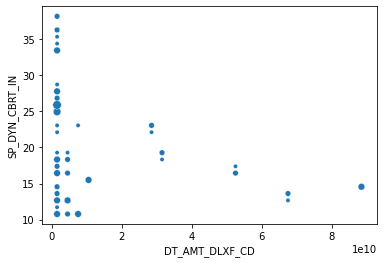

In [76]:
    # Convertimos a un Handy data frame que nos permite plotear
data_join_filter_handy = data_join_filter.toHandy()

    # Seleccionamos las columnas que nos interesan plotear para conocer su relacion
data_join_filter_handy.cols[['DT_AMT_DLXF_CD', 'SP_DYN_CBRT_IN']].scatterplot()

In [77]:
sc.stop()